In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### Dataset

In this homework, we will use the Laptops price dataset from [Kaggle](https://www.kaggle.com/datasets/juanmerinobermejo/laptops-price-dataset).

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv):


In [3]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv

--2024-09-30 19:33:07--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 298573 (292K) [text/plain]
Saving to: ‘laptops.csv’

laptops.csv         100%[===================>] 291.58K  --.-KB/s    in 0.01s   

2024-09-30 19:33:07 (24.2 MB/s) - ‘laptops.csv’ saved [298573/298573]



The goal of this homework is to create a regression model for predicting the prices (column `'Final Price'`).

### Preparing the dataset 

First, we'll normalize the names of the columns:

```python
df.columns = df.columns.str.lower().str.replace(' ', '_')
```

Now, instead of `'Final Price'`, we have `'final_price'`.

Next, use only the following columns:

* `'ram'`,
* `'storage'`,
* `'screen'`,
* `'final_price'`

In [5]:
df = pd.read_csv('laptops.csv')

In [7]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [9]:
df = df[['ram', 'storage','screen','final_price']]

In [10]:
df.head()

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


### EDA

* Look at the `final_price` variable. Does it have a long tail? 


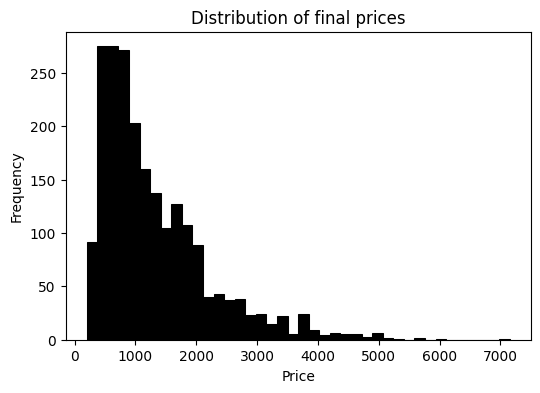

In [12]:
plt.figure(figsize=(6, 4))

sns.histplot(df.final_price, bins=40, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of final prices')

plt.show()

a small number of laptops have high prices, but a much larger number of products are priced much lower, creating a distribution with a "long tail" on the right-hand side. 

This is common in markets where a few premium or high-end products account for significant revenue, while many lower-priced products cater to niche or budget-conscious customers.

### Question 1

There's one column with missing values. What is it?


In [13]:
df.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

### Question 2

What's the median (50% percentile) for variable `'ram'`?

In [15]:
df['ram'].median()

np.float64(16.0)

### Prepare and split the dataset

* Shuffle the dataset (the filtered one you created above), use seed `42`.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.

Use the same code as in the lectures

In [39]:
np.random.seed(42)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [40]:
len(df_train), len(df_val), len(df_test)

(1296, 432, 432)

In [41]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [42]:
y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

In [43]:
del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

### Question 3

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

Options:

- With 0
- With mean
- Both are equally good


In [44]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [45]:
def prepare_X(df):
    df_num = df
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [46]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [47]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
round(rmse(y_val, y_pred), 2)

np.float64(597.36)

In [48]:
def prepare_X_mean(df):
    df_num = df
    df_num = df_num.fillna(df.mean())
    X = df_num.values
    return X

In [49]:
X_train = prepare_X_mean(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
round(rmse(y_val, y_pred),2)

np.float64(597.74)

 filling with 0 has lower RMSE than filling with mean.

### Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.01, 0.1, 1, 5, 10, 100]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If there are multiple options, select the smallest `r`.

In [50]:
r = [0, 0.01, 0.1, 1, 5, 10, 100]

In [51]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [52]:
def prepare_X(df):
    df_num = df
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [53]:
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    X_train = prepare_X(df_train)
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print('%6s' %r, round(rmse(y_val, y_pred),2))

     0 597.36
  0.01 597.36
   0.1 597.35
     1 597.21
     5 597.01
    10 597.06
   100 597.9


### Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

What's the value of std?

In [54]:
def prepare_X(df):
    df_num = df
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [55]:
rmse_list = []
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    np.random.seed(seed)
    n = len(df)
    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.shuffle(idx)
    df_shuffled = df.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()
    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values

    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']
    X_train = prepare_X(df_train)
    X_val = prepare_X(df_val)

    w_0, w = train_linear_regression(X_train, y_train)
    y_pred = w_0 + X_val.dot(w)
    print(seed, rmse(y_val, y_pred))
    rmse_list.append(rmse(y_val, y_pred))

0 565.4520868771027
1 636.7985423056726
2 588.9558697907962
3 597.8148920012521
4 571.962791511102
5 573.2383256618949
6 647.3438328407208
7 550.4398184485952
8 587.333503616991
9 576.1017929433108


In [56]:
round(np.std(rmse_list),3)

np.float64(29.176)

### Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?



In [59]:
np.random.seed(9)
n = len(df)
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)
df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()
y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

del df_train['final_price']
del df_val['final_price']
del df_test['final_price']
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)
X_test = prepare_X(df_test)

# Combine the training and validation datasets
X_train_combined = np.vstack([X_train, X_val])
y_train_combined = np.concatenate([y_train, y_val])

# Train the model on the combined dataset
w_0, w = train_linear_regression_reg(X_train_combined, y_train_combined, r=0.001)

# Make predictions on the test set
y_pred = w_0 + X_test.dot(w)

# Calculate RMSE on the test set
test_rmse = rmse(y_test, y_pred)
print("Test RMSE:", test_rmse)

Test RMSE: 608.609982204956
